In [506]:
import numpy as np
import scipy
from scipy.special import comb
from scipy.optimize import nnls
from itertools import product
import matplotlib.pyplot as plt
from matplotlib import ticker
import networkx as nx
from matplotlib import colors

# Grid Network Stuff

In [60]:
def n_links(n, m):
    return 2*n*m - (m+n)

def n_paths(n, m, exact=False):
    return comb(
        (n-1) + (m-1),
        (n-1),
        exact=exact
    )

In [61]:
N = 20
d = np.arange(N) + 1
ns, ms = np.meshgrid(d, d)

In [62]:
links = n_links(ns, ms)
paths = n_paths(ns, ms)

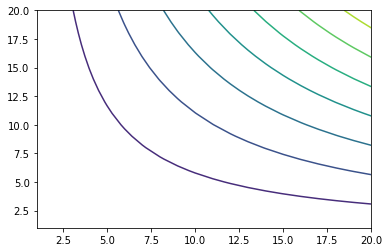

In [63]:
cs = plt.contour(ns, ms, links)

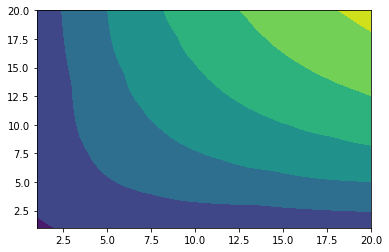

In [64]:
cs = plt.contourf(ns, ms, paths, locator=ticker.LogLocator())

In [65]:
non_unique_path_flow = paths > links + 1

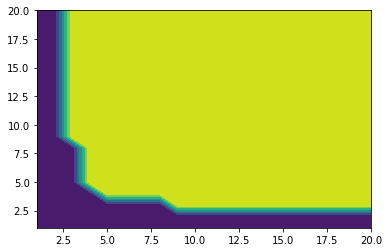

In [66]:
cs = plt.contourf(ns, ms, non_unique_path_flow)

In [73]:
n_links(4, 5), n_paths(4, 5, exact=True)

(31, 35)

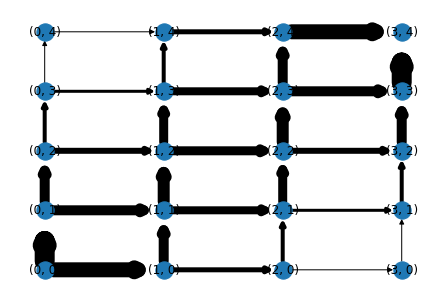

In [281]:
n, m = 4, 5
orgn = (0, 0)
dest = (n-1, m-1)
grid = nx.grid_2d_graph(n, m, create_using=nx.DiGraph)
for u, v in list(grid.edges):
    if v <= u:
        grid.remove_edge(u, v)
edge_ids = {e: i for i, e in enumerate(sorted(grid.edges))}
nx.draw(grid, {n: n for n in grid.nodes}, with_labels=True, width=x)
N_LINKS = len(edge_ids)
N_PATHS = len(pathset)
N_ODS = 1

In [122]:
pathset = sorted(map(tuple, nx.all_simple_paths(grid, source=orgn, target=dest)))

In [125]:
assert grid.number_of_edges() == n_links(n, m)
assert len(pathset) == n_paths(n, m)

In [216]:
D = np.zeros((N_LINKS, N_PATHS))
M = np.ones((N_ODS, N_PATHS))
for i, path in enumerate(pathset):
    nodes = iter(path)
    u = next(nodes)
    for v in nodes:
        D[edge_ids[(u, v)], i] = 1.0
        u = v
f = np.ones((N_PATHS, 1))
x = D.dot(f)
q = M.dot(f)

In [217]:
A = np.vstack([D, M])
b = np.vstack([x, q])
bv = b.squeeze()

In [212]:
np.linalg.matrix_rank(A), np.linalg.matrix_rank(np.hstack([A, b]))

(13, 13)

In [222]:
Q, R = np.linalg.qr(A.T)

In [223]:
Q.shape, R.shape

((35, 32), (32, 32))

In [225]:
z = np.linalg.solve(R.T, bv).squeeze()

In [227]:
f1 = Q @ z

In [231]:
abs(A @ f1 - bv).max()

2.8421709430404007e-13

In [265]:
nA = scipy.linalg.null_space(A)
nA.shape

(35, 22)

In [247]:
w, _, _, _ = scipy.linalg.lstsq(nA, f1)

In [263]:
f1, _ = nnls(A, bv)

In [264]:
abs(A @ (f1) - bv).mean()

8.604228440844963e-16

In [270]:
A @ f1

array([20., 15., 10., 10.,  4.,  6.,  1.,  3.,  1., 10.,  5., 12.,  8.,
        9.,  9.,  4.,  8.,  5.,  4.,  1.,  9.,  3., 12.,  6., 10., 10.,
       15.,  1.,  4., 10., 20., 35.])

In [271]:
A @ f.squeeze()

array([20., 15., 10., 10.,  4.,  6.,  1.,  3.,  1., 10.,  5., 12.,  8.,
        9.,  9.,  4.,  8.,  5.,  4.,  1.,  9.,  3., 12.,  6., 10., 10.,
       15.,  1.,  4., 10., 20., 35.])

In [276]:
f1.round()

array([1., 3., 0., 0., 0., 0., 2., 4., 0., 0., 0., 0., 0., 0., 5., 0., 0.,
       0., 2., 3., 1., 6., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 4., 0.,
       1.])

In [282]:
edge_ids

{((0, 0), (0, 1)): 0,
 ((0, 0), (1, 0)): 1,
 ((0, 1), (0, 2)): 2,
 ((0, 1), (1, 1)): 3,
 ((0, 2), (0, 3)): 4,
 ((0, 2), (1, 2)): 5,
 ((0, 3), (0, 4)): 6,
 ((0, 3), (1, 3)): 7,
 ((0, 4), (1, 4)): 8,
 ((1, 0), (1, 1)): 9,
 ((1, 0), (2, 0)): 10,
 ((1, 1), (1, 2)): 11,
 ((1, 1), (2, 1)): 12,
 ((1, 2), (1, 3)): 13,
 ((1, 2), (2, 2)): 14,
 ((1, 3), (1, 4)): 15,
 ((1, 3), (2, 3)): 16,
 ((1, 4), (2, 4)): 17,
 ((2, 0), (2, 1)): 18,
 ((2, 0), (3, 0)): 19,
 ((2, 1), (2, 2)): 20,
 ((2, 1), (3, 1)): 21,
 ((2, 2), (2, 3)): 22,
 ((2, 2), (3, 2)): 23,
 ((2, 3), (2, 4)): 24,
 ((2, 3), (3, 3)): 25,
 ((2, 4), (3, 4)): 26,
 ((3, 0), (3, 1)): 27,
 ((3, 1), (3, 2)): 28,
 ((3, 2), (3, 3)): 29,
 ((3, 3), (3, 4)): 30}

In [295]:
import cvxpy as cp
f = cp.Variable(N_PATHS, nonneg=True)
problem = cp.Problem(
    cp.Maximize(f[0]),
    [
        D @ f == x.squeeze(),
        M @ f == q,
    ]
)
problem.solve()

0.9999999999999998

In [322]:
f1.round()

array([1., 3., 0., 0., 0., 0., 2., 4., 0., 0., 0., 0., 0., 0., 5., 0., 0.,
       0., 2., 3., 1., 6., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 4., 0.,
       1.])

In [483]:
mc = cp.Variable(nonneg=True)
fmc = cp.Variable(nonneg=True)
c = cp.Variable(nonneg=True)
fleet = cp.Variable(N_PATHS, nonneg=True)
f = np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1.])
users = cp.Variable(N_PATHS, nonneg=True)
user_paths = cp.Variable(N_PATHS, boolean=True)
M_flow = q.max()
M_cost = 10
link_flow = x.squeeze()
eps = cp.Parameter(name="eps", value=0.1, nonneg=True)
cfs = cp.Parameter(name="cfs", value=0.2, nonneg=True)
fo_flow = f1.round()
fleet_paths = fo_flow > 0
demand = q.squeeze()
t = cp.Variable(N_LINKS, nonneg=True)
dt = cp.Variable(N_LINKS, nonneg=True)
path_marginal_cost = D.T @ (t + cp.multiply(link_flow, dt))
fleet_marginal_cost = D.T @ (t + cp.multiply(D @ fleet, dt))
path_cost = D.T @ t
problem = cp.Problem(
    cp.Maximize(cp.sum(path_cost - c)),
    #cp.Minimize(1.0),
    [
        path_marginal_cost == mc,
        path_cost >= c,
        path_cost <= c + M_cost * (1-user_paths),
        fleet_marginal_cost >= fmc,
        D @ (f + users) == link_flow,
        M @ (f + users) == demand,
        users <= M_flow * user_paths,
    ]
)
problem.solve(solver=cp.CPLEX, verbose=True)

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) Sep 10 03:48:07 PM: Your problem has 170 variables, 7 constraints, and 0 parameters.
(CVXPY) Sep 10 03:48:07 PM: It is compliant with the following grammars: 
(CVXPY) Sep 10 03:48:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 10 03:48:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.


DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
var12971 <= [[1. 0. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 1. 1.]
 [0. 1. 0. ... 1. 1. 1.]
 [0. 1. 0. ... 1. 1. 1.]] @ (var12978 + [[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]] @ var12973 @ var12979) , because the following subexpressions are not:
|--  [[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]] @ var12973 @ var12979

In [481]:
path_marginal_cost.value, path_cost.value

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]))

In [482]:
t.value, dt.value

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [478]:
users.value

array([-0.,  3.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  5.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  3.,  0.,  0.,  2.,  0.,  4.,  0.,
        0.,  4.,  0.,  0.,  4.,  0.,  0.,  0., -0.])

<ipython-input-519-df38bb3b999e>:7: UserWarning: Log scale: values of z <= 0 have been masked
  cs = plt.contour(X, Y, Z, levels, norm=colors.LogNorm())


Text(0, 0.5, 'Fraction funded')

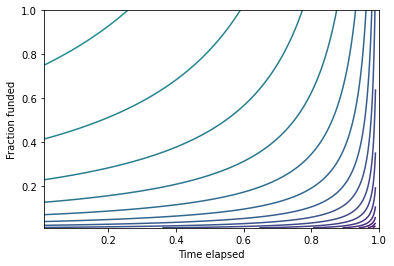

In [519]:
d = np.linspace(0.01, 1, 100)
X, Y = np.meshgrid(d, d)
Z = Y * (1 - X)
#cs = plt.contour(X, Y, Z, locator=ticker.LogLocator())
#cbar = plt.colorbar(cs)
levels = np.logspace(-4, 4, 32)
cs = plt.contour(X, Y, Z, levels, norm=colors.LogNorm())
plt.xlabel("Time elapsed")
plt.ylabel("Fraction funded")